In [35]:
import pandas as pd 
import numpy as np 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df = df.drop('id', axis=1)

In [37]:
bmiPipe = Pipeline(steps=[('scale',StandardScaler()),
                    ('lr',DecisionTreeRegressor())
                    ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

missingDF = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
bmiPipe.fit(X,Y)
predictedBMI = pd.Series(bmiPipe.predict(missingDF[['age','gender']]), index=missingDF.index)
df.loc[missingDF.index, 'bmi'] = predictedBMI

In [38]:
df.gender = df.gender.replace({'Male':0,'Female':1, 'Other':-1}).astype(np.uint8)
df.ever_married = df.ever_married.replace({'No':0, 'Yes':1}).astype(np.uint8)
df.Residence_type = df.Residence_type.replace({'Urban':0, 'Rural':1}).astype(np.uint8)

In [39]:
toDummies = ['work_type', 'smoking_status']
df = pd.get_dummies(df, columns=toDummies, prefix='', prefix_sep='')

In [40]:
Y = df['stroke']
X = df.drop('stroke', axis=1)

In [41]:
ros = RandomOverSampler(sampling_strategy = 0.5)
x_res, y_res = ros.fit_resample(X, Y)
y_res.value_counts()

0    4861
1    2430
Name: stroke, dtype: int64

In [42]:
le = preprocessing.LabelEncoder()
X = X.apply(le.fit_transform)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=123)

In [44]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

In [58]:
parameters = {
        'n_estimators': stats.randint(100, 1250),
        'learning_rate': stats.uniform(0.01, 1),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0, 2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6, 7, 8, 9, 10]
        }

XGB = XGBClassifier()

RS = RandomizedSearchCV(XGB, param_distributions=parameters, n_iter=5, n_jobs=-2, cv=5, verbose=4, random_state=123)

RS.fit(train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                  

In [59]:
xgbPrediction = RS.best_estimator_.predict(test_scaled)

In [60]:
xgbAcc1 = accuracy_score(y_test, xgbPrediction)

0.9725839616175462

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


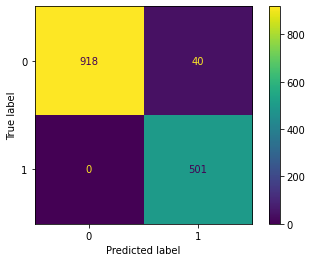

In [61]:
plot_confusion_matrix(RS.best_estimator_, test_scaled, y_test)

plt.show()

In [62]:
print(f'Best parameters: {RS.best_params_}')

Best parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.6948297385848633, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1042, 'subsample': 0.6}


<AxesSubplot:>

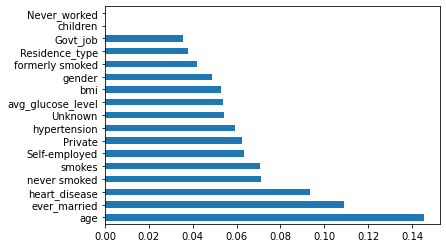

In [63]:
(pd.Series(RS.best_estimator_.feature_importances_, index=X.columns)
   .nlargest(17)
   .plot(kind='barh'))

In [51]:
MLP = MLPClassifier(max_iter=50)

parameters = {
    'hidden_layer_sizes': [(75,75,75), (75,125,75), (125,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

GSCV = GridSearchCV(MLP, parameters, n_jobs=-1, cv=3)

GSCV.fit(train_scaled, y_train)

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=50), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(75, 75, 75), (75, 125, 75),
                                                (125,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [52]:
mlpPrediction = GSCV.predict(test_scaled)

In [53]:
mlpAcc1 = accuracy_score(y_test, mlpPrediction)

0.9204934886908842

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


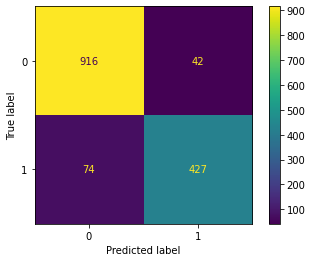

In [54]:
plot_confusion_matrix(GSCV, test_scaled, y_test)
plt.show()

In [55]:
print(f'Best parameters: {GSCV.best_params_}')

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (75, 125, 75), 'learning_rate': 'constant', 'solver': 'adam'}


In [68]:
bestDf = df[['age', 'ever_married', 'heart_disease', 'never smoked', 'smokes', 'Self-employed', 'Private', 'hypertension', 'stroke']]

In [69]:
Y = bestDf['stroke']
X = bestDf.drop('stroke', axis=1)

In [70]:
ros = RandomOverSampler(sampling_strategy = 0.5)
x_res, y_res = ros.fit_resample(X, Y)
le = preprocessing.LabelEncoder()
X = X.apply(le.fit_transform)
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=123)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

In [74]:
parameters = {
        'n_estimators': stats.randint(100, 1250),
        'learning_rate': stats.uniform(0.01, 1),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0, 2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6, 7, 8, 9, 10]
        }

XGB = XGBClassifier()

RS = RandomizedSearchCV(XGB, param_distributions=parameters, n_iter=5, n_jobs=-2, cv=5, verbose=4, random_state=123)

RS.fit(train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                  

In [75]:
xgbPrediction = RS.best_estimator_.predict(test_scaled)

In [76]:
xgbPred2 = accuracy_score(y_test, xgbPrediction)

0.8910212474297464

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


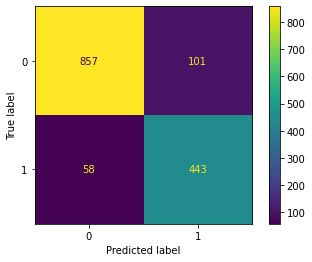

In [78]:
plot_confusion_matrix(RS.best_estimator_, test_scaled, y_test)

plt.show()

In [80]:
MLP = MLPClassifier(max_iter=50)

parameters = {
    'hidden_layer_sizes': [(75,75,75), (75,125,75), (125,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

GSCV = GridSearchCV(MLP, parameters, n_jobs=-1, cv=3)

GSCV.fit(train_scaled, y_train)

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=50), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(75, 75, 75), (75, 125, 75),
                                                (125,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [81]:
mlpPrediction = GSCV.predict(test_scaled)

In [82]:
mlpAcc2 = accuracy_score(y_test, mlpPrediction)

0.8231665524331734

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


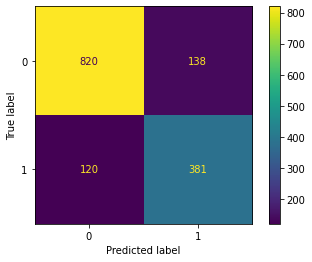

In [83]:
plot_confusion_matrix(GSCV, test_scaled, y_test)
plt.show()